In [1]:
import os

import arviz as az                               # for exploratory analysis of Bayesian models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy as sp
import seaborn as sns
import xarray as xr
import plotly.figure_factory as ff              # for ternery heatmaps

# Dirichlet Process Mixture Models
## Part 1: Introduction to Dirichlet Process

### 1.1 Parametric vs Non-parametric Bayesian models
* In case of a **parametric bayesian model**, we use a class of parametric densities  as our model $\mathcal{M}_p = \{ f(x|\theta) | \theta \in \Theta \}$.Here, $\Theta$ is a finite dimensional parameter space. 
$$
\quad \quad X_1, X_2, \cdots, X_n \sim f(\cdot|\theta) \text{ for unknown } \theta \\
\theta \sim \pi(\cdot)
$$
We use Bayes' rule to compute the posterior distribution $\pi(\theta|x)$ to perform further analysis.

* In case of a **non-parametric Bayesian model**, we use a more general class of densities as our model. 

$$
\mathcal{M}_{np} = \left\{ f : \int{[f(x)'']^2 \mathrm{d}x < \infty} \right\}
$$

The model summary in this scenario will be:
$$
\quad \quad X_1, X_2, \cdots, X_n \sim F  \text{ for some unknown } F\\
F \sim \mathcal{P}(\cdot) \text{ where } \mathcal{P} \text{ is a well-defined prior probability on } \mathcal{M}_{np}
$$

* Typically, in the non-parametric case, neither the prior nor the posterior have a density function with respect to a dominating measure. But the posterior is still well defined.

* On the other hand, if there is a dominating measure for a set of densities $\mathcal{M}_{np}$ then the posterior can be found by Bayes theorem.

* Dirichlet Process is a popular choice for $\mathcal{P}$ since it provides tractable posterior computations. Hence DPs are often used in Bayesian non-parametric models of data. 

* DPs are particularly used in Dirichlet Process Mixture Models (DPMM). DPMMs are also called **infinite mixture models**. 

* DPs are distributions over distributions. Therefore, a random draw from a Dirichlet Process is a _discrete distribution_. Note that the draws from a DP cannot be described using a finite number of parameters. 

### 1.2 Review of Stochastic processes
Consider a stochastic process $\mathbb{X} = \{ X_t \}_{t \in T}$ on the space $(\Omega, \mathcal{F}, \mathbb{P})$ where each $X_t$ is a random variable with support $S$. $S$ is called the _state space_ i.e. all possible "states" at a given time $t$. Note that each random variable is a measurable function i.e. $X_t : \Omega \longrightarrow S$.

There are two equivalent definitions of Stochastic processes

**Definition 1**: \
$
\mathbb{X} : \Omega \times T \longrightarrow S \\
\quad  (\omega, t) \mapsto X(\omega, t) \equiv X_t(\omega) 
$

**Definition 2**: Let $\mathbb{F}$ be a well-defined function space on $(\Omega, \mathcal{F}, \mathbb{P})$\
$
\mathbb{X}: T \longrightarrow \mathbb{F} \\
\quad \quad t \mapsto X_t \text{  where  } X_t : \Omega \longrightarrow S
$

Some observations:
1. $X(\cdot, t)$ is a random variable in the position varible $\omega$ while $X(\omega, \cdot)$ is a random variable in time $t$.
2. The set $\{ X(\omega_0, t) | t \in T \}$ is a **sample path** of the Stochastic process $\mathbb{X}$.
3. Using definition 2, we can interpret stochastic processes as distribution over function space. A _random function_ $X_t$ is drawn at _random_ at time $t$.
4. Dirichlet processes are stochastic processes that draw a special  function, probability measure, ------------CHECK

### 1.3 Dirichlet Distribution
* Dirichlet distribution is a multivariate continuous distribution with $k-1$-simplices as support if $\alpha$ is $k$-dimensional.
* Dirichlet distribution is a generalization of Beta distribution which is defined on the $1$-simplex $[0,1]$.

Let random vector $\vec{X}$ and parameter $\vec{\alpha}$ are $k$-dimensional. Then $\vec{X} \sim Dir(\vec{\alpha})$ with $\alpha_i > 0 \quad  \forall i \in \{1,2 \cdots,n\}$ has the following density function:

$
f(x_1, \cdots, x_k) = \dfrac{\Gamma(\sum_{i=1}^k)}{\sum_{i=1}^k \Gamma(\alpha_i)} \cdot \prod_{i=1}^k x_i^{\alpha_i - 1} \text{ for } x \in \mathbb{S}^{k-1} = \{x \in \mathbb{R}^k | \sum_{i=1}^k = 1 \text{ and } x_i \geq 0 \forall i\}
$

* $\vec{\alpha}$ is called the concentration parameter as they control how dispersed or concentrated the points are in $\mathbb{S}^k$.

##### Visualization to understand the role of concentration parameter.

Consider data sampled from $Dir(\alpha)$ for $\alpha = (\alpha_1, \alpha_2, \alpha_3)$

In [2]:
# checking how the functions work
quantiles = np.array([0.2, 0.2, 0.6])
alpha = np.array([0.4, 5, 15])
sp.stats.dirichlet.pdf(quantiles, alpha)

0.2843831684937255

--------------------------------------------------------------------------------------------

### 1.4 Dirichlet Process
Let $G$ be a random distribution defined on $\Theta$ i.e. $G: \Theta \longrightarrow [0,1]$ is a _random_ measure. 

Let $\alpha >0$ and $H$ be a probability measure over $\Theta$. We say $G \sim DP(\alpha, H)$ if for any measurable partition $\{A_1, A_2, \cdots, A_r\}$ of $\Theta$, we have

$$
\left( G(A_1), G(A_2), \cdots, G(A_r) \right) \sim Dir(\alpha H(A_1), \alpha H(A_2), \cdots, \alpha H(A_r))
$$

Since $G$ is a random measure (function), $G(A)$ is a well-defined random variable for any measurable set $A \subseteq \Theta$.

**Intuituon:** 
1. The _base measure_ $H$ plays the role of average i.e. draws from the DP are centered around $H$.
2. and $\alpha$ quantifies inverse variance. In case of a larger $\alpha$, a draw from the DP will have its mass concentrated closer to and around $H$. For this reason, $\alpha$ is called **concetration parameter** or **strength parameter**.


**Important property about DP**\
If the topological support of the base measure $H$ is $\Theta$, then any distribution over $\Theta$ can be approximated (with arbitrary accuracy) using a seuqence of draws from $DP(\alpha, H)$ 

**Variance and Expectation**
For any measurable set $A \subseteq \Theta$,
1. $\mathbb{E}[G(A)] = H(A)$
2. $Var[G(A)] = \dfrac{H(A)[1-H(A)]}{\alpha + 1}$

In [3]:
%config InlineBackend.figure_format = 'retina'

# rng is a random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# select a matplotlib style: https://python.arviz.org/en/stable/examples/styles.html
az.style.use("arviz-whitegrid")

### 1.5 Drawing measures from a Dirichlet Process 
**Example** \
Consider $Dir(\alpha, H_0)$ where $\alpha = 2$ and $H_0 \equiv \mathcal{N}(0,1)$. In this example, we will use **stick breaking process** to sample draws (cdf) from $Dir(\alpha, H_0)$

In [4]:
N = 20 # num of draws
K = 30 # num of simulations

# DP concentration parameter
alpha = 2.0
# DP base distribution
H0 = sp.stats.norm

**Stick Breaking process** is one way to randomly draw a probability measure $P$ from $Dir(\alpha, P_0)$:

1. IID draws $s_0,s_1, s_2 \cdots \equiv P_0$ i.e. from base distribution.
2. IID draws $v_0, v_1, v_2 \cdots \equiv Beta(1, \alpha)$
3. Define weights $w_0, w_1, w_2, \cdots$ as follows:

$
\begin{aligned}
w_0 &= v_0 \\
w_1 &= v_1(1-v_0) \\
\cdots \\
w_j &= v_j \prod_{i=1}^{j-1} (1-v_j) 
\end{aligned}
$

4. The distribution $P$ defined as follows is a draw from $Dir(\alpha, P_0)$: $\quad P \triangleq \sum_{j=0}^{\infty} w_j \mathbb{I}(s_j)$


In [5]:
# construct a N*K array with draws from Beta(1, alpha) 
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))

# Return a new array with the same shape and type as the beta array.
# So w is 20*30 array
w = np.empty_like(beta)

# w_0 = v_0 for all K simulations
w[:, 0] = beta[:, 0]
# compute w_j for each of the K simulations
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

# s_0,s_1... drawn from base distribution P_0
omega = H0.rvs(size=(N, K))

# DataArray is a special datastructure with properties - values, dims, coords, attrs
x_plot = xr.DataArray(np.linspace(-3, 3, 200), dims=["plot"])

# ... means all existing dimensions and np.newaxis creates new axis, so w is now of size N*K*1
# outer makes sure that all pairwise comparisons happen
sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot.values)).sum(axis=1)

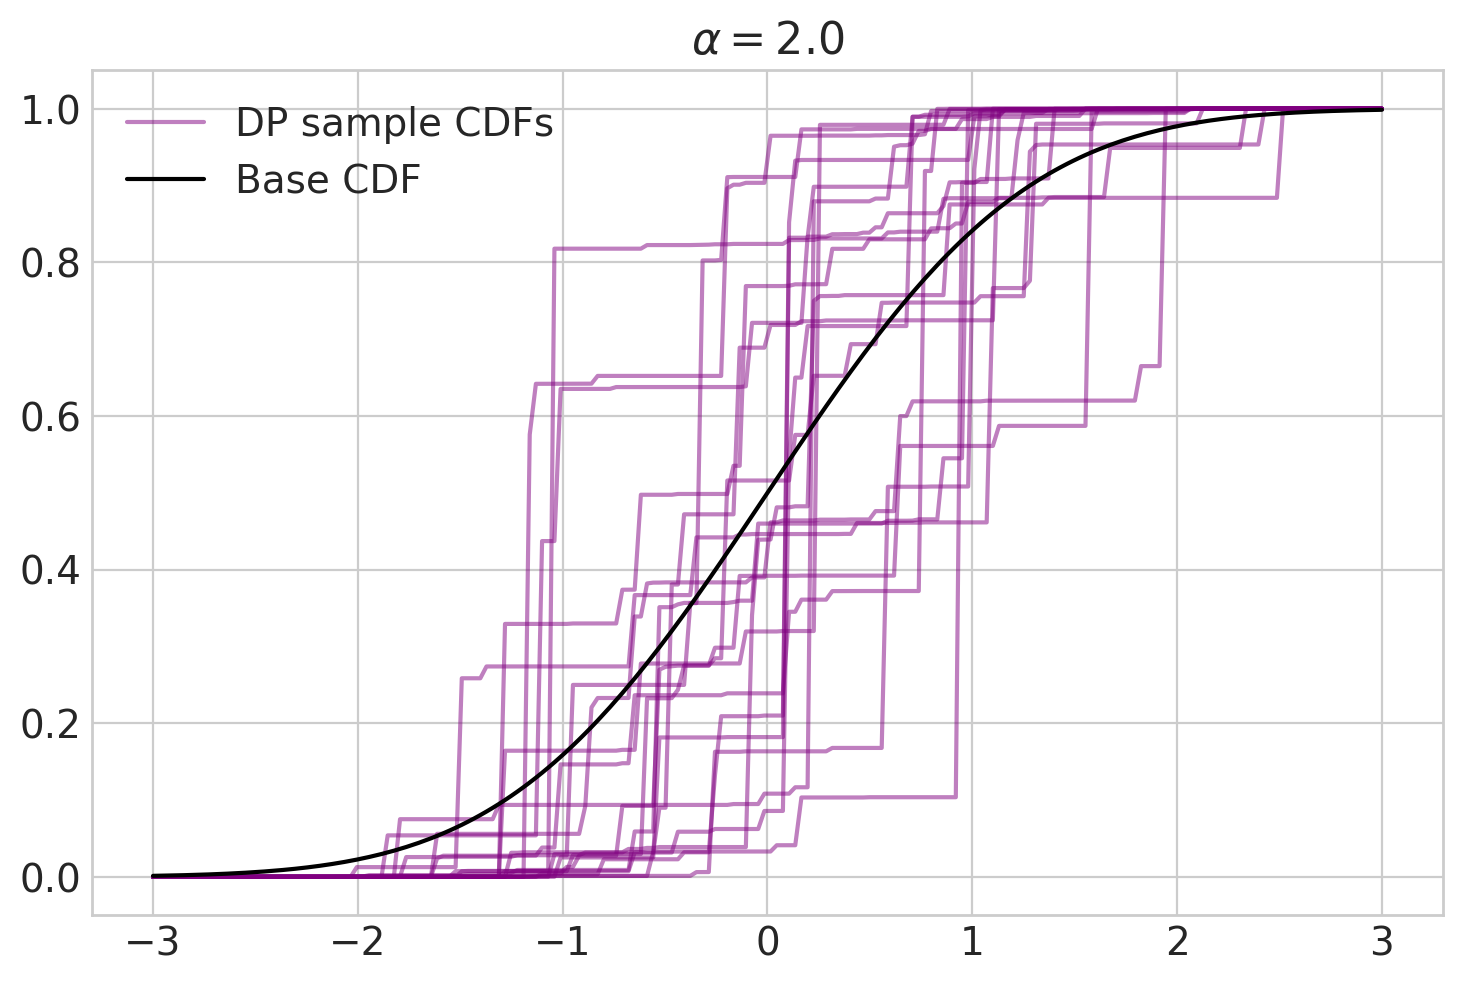

In [6]:
# plt.subplots() always returns figure (here, it is stored in fig) and array of axes (stored in ax, in this case)
# figsize=(8, 6)
fig, ax = plt.subplots()

# alpha controls opaqueness
# check why transpose was used
ax.plot(x_plot, sample_cdfs[0], c="purple", alpha=0.5, label="DP sample CDFs")
ax.plot(x_plot, sample_cdfs[1:].T, c="purple", alpha=0.5)
ax.plot(x_plot, H0.cdf(x_plot), c="k", label="Base CDF")

ax.set_title(rf"$\alpha = {alpha}$")
ax.legend(loc=2); # legend locations : 1,2, 3, 4

**Comparing the nature of draws for different $\alpha$ values**\
Let us use one of the previous code blocks to define a function that draws $N$ sample points from $Dir(\alpha, H_0)$ for $K$ many simulations.

In [11]:
# alpha = concentration parameter
# H0 = base measure
# N = num of samples and K = num of simulations
# x_min, x_max determine the support/sub-support of H0 the plot should use
def Dir_Process_sampler(alpha, H0, N, K, x_min, x_max):
    beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
    
    w = np.empty_like(beta)
    w[:, 0] = beta[:, 0]
    w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

    omega = H0.rvs(size=(N, K))
    x_plot = xr.DataArray(np.linspace(x_min, x_max, 200), dims=["plot"])
    sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot.values)).sum(axis=1)

    return(sample_cdfs, x_plot, omega, w)
    

In [12]:
sample_cdfs_3 = Dir_Process_sampler(alpha=3,H0=H0, N = N, K=K, x_min=0, x_max=50 )
sample_cdfs_3[0].shape

# instead use this
sample_cdfs_3, x_plot_3 = Dir_Process_sampler(alpha=3,H0=H0, N = N, K=K, x_min=0, x_max=50 )

ValueError: too many values to unpack (expected 2)

In [10]:
# fix num of simulations to 100
K = 100
base_measure = sp.stats.poisson(4)
N = 60
omega = H0.rvs(size=(N, K))

# obtain sample cdfs for diff alpha values
sample_cdfs_half, x_plot_half = Dir_Process_sampler(alpha=0.5,H0=base_measure, N = N, K=K, x_min=0, x_max=20 )
sample_cdfs_3, x_plot_3 = Dir_Process_sampler(alpha=3,H0=base_measure, N = N, K=K, x_min=0, x_max=20 )
sample_cdfs_8, x_plot_8 = Dir_Process_sampler(alpha=8,H0=base_measure, N = N, K=K, x_min=0, x_max=20 )
sample_cdfs_15, x_plot_15 = Dir_Process_sampler(alpha=15,H0=base_measure, N = N, K=K, x_min=0, x_max=20 )

# plt.subplots is similar to "par(mfrow = )" in R
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(10, 8))

# alpha = 1/2
ax1.plot(x_plot_half, sample_cdfs_half[0], c="purple", alpha=0.25, label="DP sample CDFs")
ax1.plot(x_plot_half, sample_cdfs_half[1:].T, c="purple", alpha=0.25)
ax1.plot(x_plot_half, base_measure.cdf(x_plot_half), c="k", label="Base CDF")
ax1.set_title("H = Pois(4), alpha = 0.5")
ax1.legend(loc=4)

# alpha = 3
ax2.plot(x_plot_3, sample_cdfs_3[0], c="purple", alpha=0.25, label="DP sample CDFs")
ax2.plot(x_plot_3, sample_cdfs_3[1:].T, c="purple", alpha=0.25)
ax2.plot(x_plot_3, base_measure.cdf(x_plot_3), c="k", label="Base CDF")
ax2.set_title("H = Pois(4), alpha = 3")
ax2.legend(loc=4)

# alpha = 8
ax3.plot(x_plot_8, sample_cdfs_8[0], c="purple", alpha=0.25, label="DP sample CDFs")
ax3.plot(x_plot_8, sample_cdfs_8[1:].T, c="purple", alpha=0.25)
ax3.plot(x_plot_8, base_measure.cdf(x_plot_8), c="k", label="Base CDF")
ax3.set_title("H = Pois(4), alpha = 8")
ax3.legend(loc=4)

# alpha = 15
ax4.plot(x_plot_15, sample_cdfs_15[0], c="purple", alpha=0.25, label="DP sample CDFs")
ax4.plot(x_plot_15, sample_cdfs_15[1:].T, c="purple", alpha=0.25)
ax4.plot(x_plot_15, base_measure.cdf(x_plot_15), c="k", label="Base CDF")
ax4.set_title("H = Pois(4), alpha = 15")
ax4.legend(loc=4)

ValueError: too many values to unpack (expected 2)

**Note**: As $\alpha \longrightarrow \infty$, the samples from DP converge to base distribution weakly.

### Posterior distribution
Let $G \sim DP(\alpha)$ where $G: \Theta \longrightarrow [0,1]$ is a random measure \
Let $\theta_1, \theta_2, \cdots, \theta_n \overset{\mathrm{iid}}{\sim} G$

Then the posterioir distribution is a weighted sum of prior and empirical distributions.
$$
G \Big\vert \theta_1, \cdots, \theta_n \thicksim DP\left( \alpha + n, \dfrac{\alpha}{\alpha + n}H + \dfrac{n}{\alpha + n} \cdot \frac{1}{n} \cdot \left \{ \sum_{i=1}^n \mathbb{I}_{\theta_i} \right\} \right)
$$


### Predictive Distribution
We know that $\theta_{n+1} \Big \vert G, \theta_1, \cdots, \theta_n \sim G$. Then,
$$
\theta_{n+1} \Big \vert \theta_1, \cdots, \theta_n \sim \dfrac{\alpha}{\alpha + n}H + \dfrac{n}{\alpha + n} \cdot \frac{1}{n} \cdot \sum_{i=1}^n \mathbb{I}_{\theta_i}
$$

## Part 2: DP based clustering method

In [10]:
N = 5     # num of draws
K = 30    # num of simulations

alpha = 2
P0 = sp.stats.norm

# define pdf function f using the python lambda function
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)

In [15]:
sample_dpm, x_plot_dpm, theta_dpm, w_dpm = Dir_Process_sampler(alpha=alpha, H0=P0, N=N, K=K, x_min=-3, x_max=3)

dpm_pdf_components = f(x_plot, theta_dpm[..., np.newaxis])
dpm_pdfs = (w_dpm[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

dpm_pdf_components.shape

(5, 30, 200)

### References:
1. Teh, Y. (2011). __Dirichlet Process__. In: Sammut, C., Webb, G.I. (eds) _Encyclopedia of Machine Learning_. Springer, Boston, MA. \
DOI: https://doi.org/10.1007/978-0-387-30164-8_219 \
Also available as lecture notes on Yee Whye Teh's [website](https://www.stats.ox.ac.uk/~teh/npbayes.html)
2. Larry Wasserman's (Spring 2019) [lecture notes](https://www.stat.cmu.edu/~larry/=sml/) on Non-parametric Bayesian methods for the course STAT 36-708: Statistical Methods for Machine Learning at CMU.